In [155]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.preprocessing import MinMaxScaler
import pickle 

In [2]:
df = pd.read_csv("./spam.csv", encoding='latin1')
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
2735,ham,I meant middle left or right?,NaN,NaN,NaN
2039,ham,Dont pack what you can buy at any store.like c...,NaN,NaN,NaN
1547,ham,Bishan lar nearer... No need buy so early cos ...,NaN,NaN,NaN
3701,ham,Hey loverboy! I love you !! I had to tell ... ...,NaN,NaN,NaN
1769,ham,Ha... Both of us doing e same thing. But i got...,NaN,NaN,NaN


## Data cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
df.sample(5)

,v1,v2
3129,ham,Ok. But i finish at 6.
4414,ham,"Yeah I should be able to, I'll text you when I..."
1964,ham,Honeybee Said: *I'm d Sweetest in d World* God...
3631,ham,Oooh I got plenty of those!
4882,ham,"New Theory: Argument wins d SITUATION, but los..."


In [5]:
df["v1"].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

In [6]:
df.rename(columns={"v1": "target", "v2": "text"}, inplace=True)
df.sample(5)

,target,text
897,ham,I'm used to it. I just hope my agents don't dr...
5259,ham,Can help u swoop by picking u up from wherever...
684,ham,I wanted to ask Ì_ to wait 4 me to finish lect...
3152,ham,I tagged MY friends that you seemed to count a...
1003,ham,&lt;#&gt; am I think? Should say on syllabus


In [7]:
encoder = LabelEncoder()
df["target"] = encoder.fit_transform(df["target"])

In [8]:
df.head(5)

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [10]:
df.duplicated().sum()

403

In [11]:
df = df.drop_duplicates(keep="first")

In [12]:
df.duplicated().sum()

0

In [13]:
df.shape

(5169, 2)

In [14]:
df["target"].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

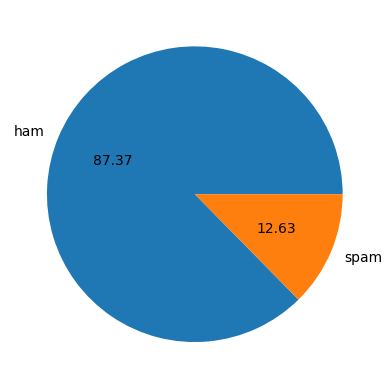

In [15]:
plt.pie(df["target"].value_counts(), labels=['ham', 'spam'], autopct='%0.2f')
plt.show()

In [16]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
df['num_characters'] = df['text'].apply(len)

In [18]:
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [19]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [20]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [21]:
df[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [22]:
# ham
df[df['target'] == 0][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [23]:
# spam
df[df['target'] == 1][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

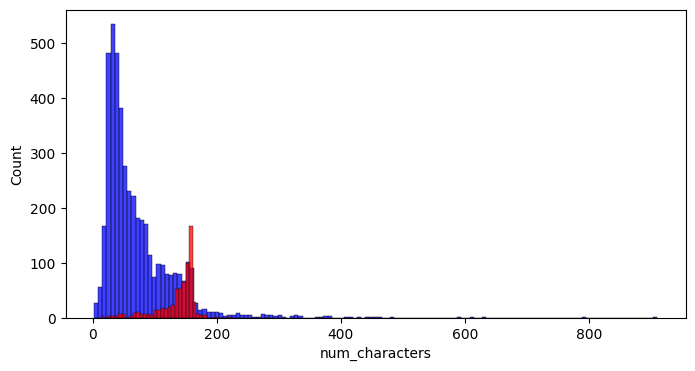

In [29]:
plt.figure(figsize=(8,4))
# ham
sns.histplot(df[df['target'] == 0]['num_characters'], color='blue')
# spam
sns.histplot(df[df['target'] == 1]['num_characters'], color='red')

<Axes: xlabel='num_words', ylabel='Count'>

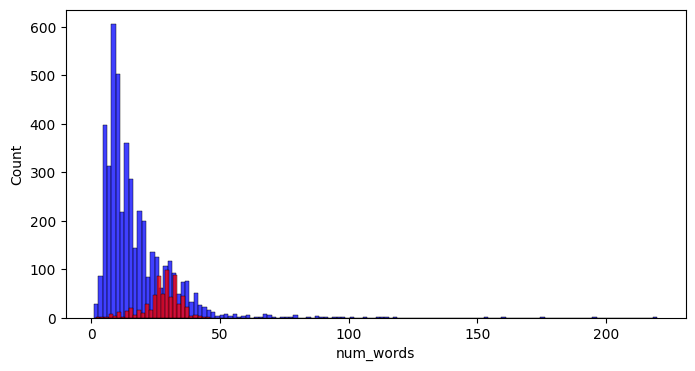

In [30]:
plt.figure(figsize=(8,4))
# ham
sns.histplot(df[df['target'] == 0]['num_words'], color='blue')
# spam
sns.histplot(df[df['target'] == 1]['num_words'], color='red')

C:\Users\Jou\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


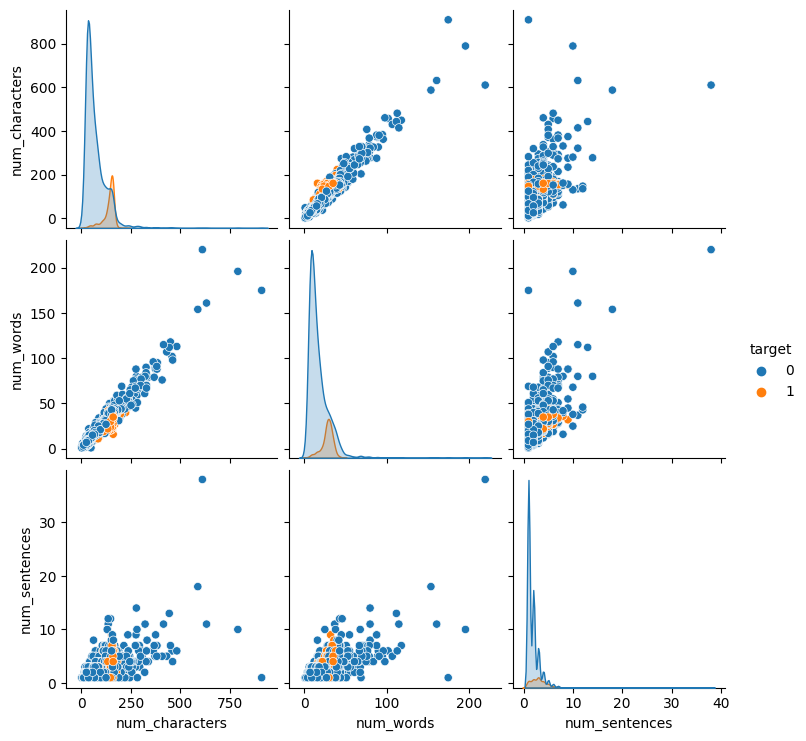

In [31]:
sns.pairplot(df, hue='target')

In [33]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


<Axes: >

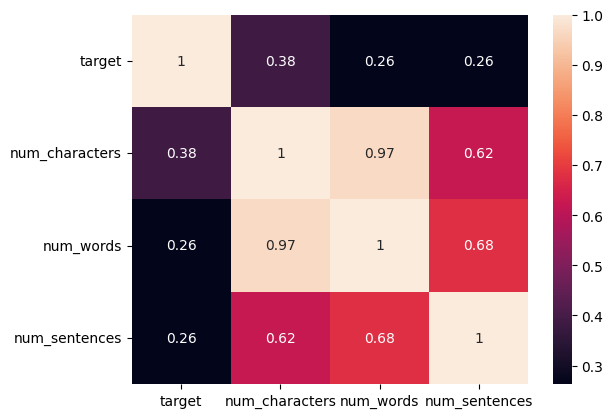

In [38]:
sns.heatmap(df.drop(columns='text').corr(), annot=True)

# Data preprocessing 
- lower case
- tokenization
- stemming
- removing stop words and punctuation
- removing special characters

In [81]:
def transform_text(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token.isalnum()]
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation]
    ps = PorterStemmer()
    tokens = [ps.stem(token) for token in tokens]
    return " ".join(tokens)

In [82]:
transform_text('I loved YT videos on machine learning, How about You?')

'love yt video machin learn'

In [83]:
transform_text(df['text'][10])

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [87]:
df['transformed_text'] = df['text'].apply(transform_text)

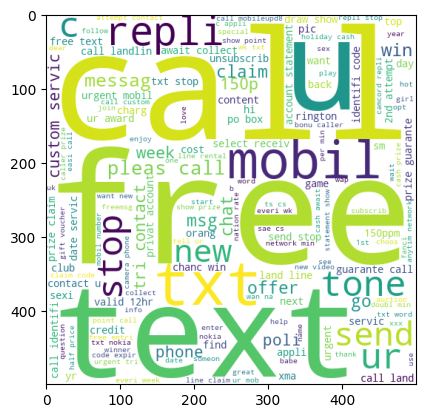

In [91]:
wc = WordCloud(width=500, height=500, background_color='white', min_font_size=10)
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=' '))
plt.imshow(spam_wc)

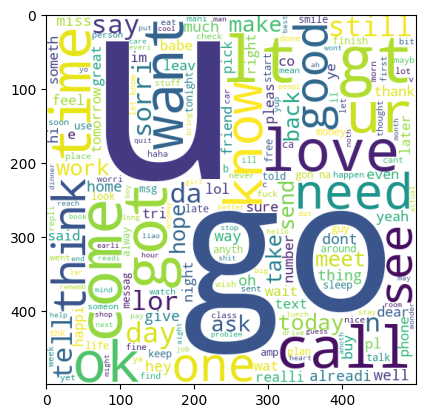

In [92]:
wc = WordCloud(width=500, height=500, background_color='white', min_font_size=10)
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=' '))
plt.imshow(ham_wc)

In [108]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
len(spam_corpus)

9939

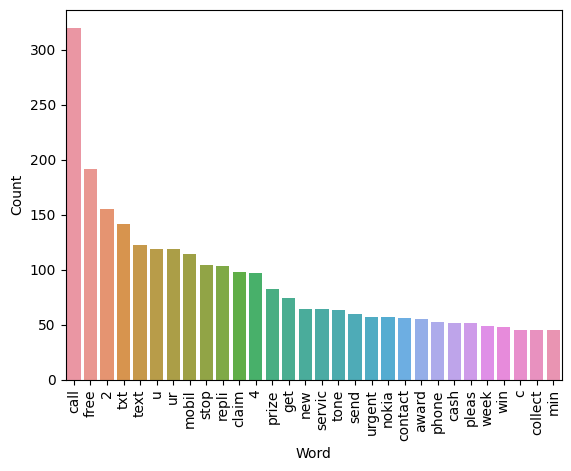

In [107]:
spam_counter = Counter(spam_corpus)
most_common_words = spam_counter.most_common(30)
df_most_common = pd.DataFrame(most_common_words, columns=['Word', 'Count'])
ax = sns.barplot(x='Word', y='Count', data=df_most_common)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [109]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
len(ham_corpus)

35404

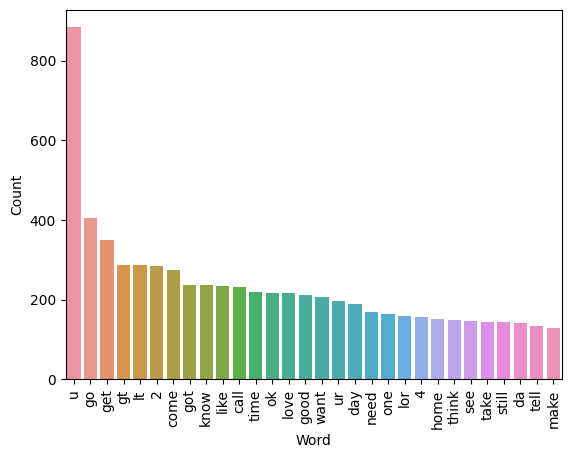

In [110]:
ham_counter = Counter(ham_corpus)
most_common_words = ham_counter.most_common(30)
df_most_common = pd.DataFrame(most_common_words, columns=['Word', 'Count'])
ax = sns.barplot(x='Word', y='Count', data=df_most_common)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

# Model building

In [165]:
cv = CountVectorizer()
X = cv.fit_transform(df['transformed_text']).toarray()

In [166]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [167]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

In [168]:
X.shape

(5169, 3000)

In [169]:
y = df['target'].values

In [170]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

Accuracy:  0.8694390715667312
Precesion score:  0.5068493150684932


<Axes: >

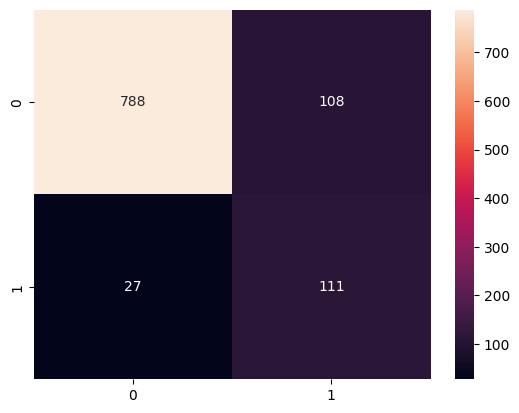

In [172]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred_gnb))
print("Precesion score: ", precision_score(y_test, y_pred_gnb))
sns.heatmap(confusion_matrix(y_test, y_pred_gnb), annot=True, fmt='.0f')

Accuracy:  0.9709864603481625
Precesion score:  1.0


<Axes: >

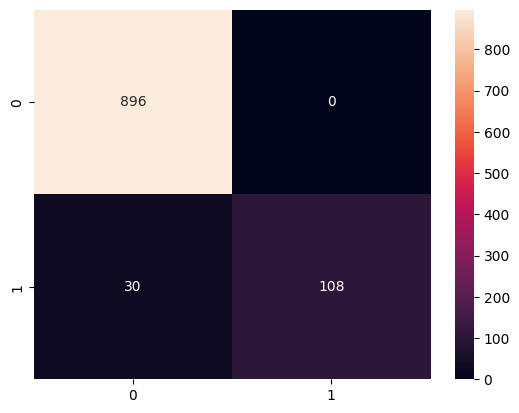

In [173]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred_mnb))
print("Precesion score: ", precision_score(y_test, y_pred_mnb))
sns.heatmap(confusion_matrix(y_test, y_pred_mnb), annot=True, fmt='.0f')

Accuracy:  0.9835589941972921
Precesion score:  0.991869918699187


<Axes: >

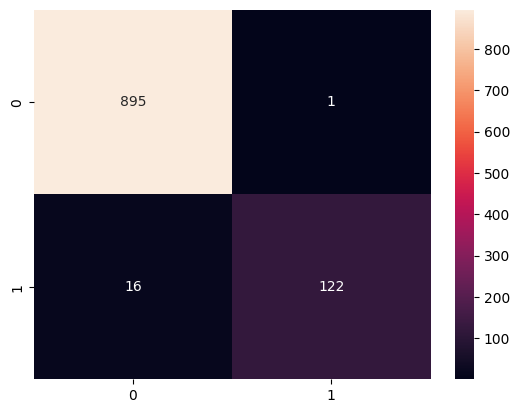

In [174]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_pred_bnb = bnb.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred_bnb))
print("Precesion score: ", precision_score(y_test, y_pred_bnb))
sns.heatmap(confusion_matrix(y_test, y_pred_bnb), annot=True, fmt='.0f')

In [176]:
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))